In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import pints
import pints.toy as toy

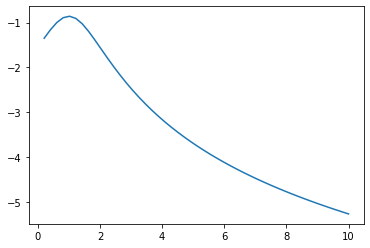

-5.2637670606618725

In [2]:
# Parameters (& hyper parameters)
theta_data = [28, 8, -3, 7, -1, 1, 18, 12] # measured average score for each school
sigma_data = [15, 10, 16, 11, 9, 11, 10, 18] # measured score SD for each school
mu = 1 # overall mean score
tau = 1 # overall score SD

# What is gaussianlogprior?
prior = pints.HalfCauchyLogPrior(mu, tau)
nums = [n/10 for n in np.linspace(0,100)]
test = [prior([n]) for n in nums]
#testcdf = prior.cdf()
plt.figure()
plt.plot(nums, test)
#plt.plot(nums, testcdf)
plt.show()

prior([10])

In [3]:
# Stolen entirely from pints eightschools

def loglikelihood_8schools(x, y_data):
    # x is proposed parameters, we're finding numerator of Bayes' rule
    if len(x) != 10:
        raise ValueError('Input parameters must be of length 10.')
    mu = x[0] # overall mean
    tau = x[1] # overall variance
    thetas = x[2:] # mean per school
    lk_of_theta = 0
    lk_of_data = 0
    # priors
    log_prior = pints.GaussianLogPrior(mu, tau) # prior pdf of theta
    mu_log_prior = pints.GaussianLogPrior(0,5) # prior pdf, centred on zero (no avg effect)
    tau_log_prior = pints.HalfCauchyLogPrior(0,5) # prior pdf, why centre zero???
    
    lk_of_mu = mu_log_prior([mu]) # log likelihood of mu
    lk_of_tau = tau_log_prior([tau]) # log likelihood of tau

    # nb. theta_tilde is the proposed theta (rather than data theta) I think?
    for i, theta_tilde in enumerate(thetas): # go through each proposed school mean
        lk_of_theta += log_prior([theta_tilde]) # log likelihood of theta

        log_prior_2 = pints.GaussianLogPrior(theta_tilde, sigma_data[i]) 
        lk_of_data += log_prior_2([y_data[i]]) # log likelihood of data given theta?

    return lk_of_mu + lk_of_tau + lk_of_theta + lk_of_data


In [4]:
# Let's compare this to pints to make sure it works
customtest = loglikelihood_8schools(np.ones(10), theta_data)
pintsmodel = toy.EightSchoolsLogPDF()
pintstest = pintsmodel(np.ones(10))

`evaluateS1` returns the LogPDF, plus the partial derivatives of the LogPDF with respect to the parameters. The partial derivatives in this case are given by:-  
$\frac{\partial logPDF}{\partial \mu} = $  
$\frac{\partial (logPDF)}{\partial \tau} = \frac{(\theta-\mu)^2-\tau^2}{\tau^3}$  
$\frac{y_j-\theta}{\sigma_j^2}$

In [17]:
# Pints MCMC
class pints8schools(pints.LogPDF):
    def __init__(self):
        self._n_parameters = 10
    def __call__(self, x, y_data=theta_data): 
        return loglikelihood_8schools(x, y_data)
    def n_parameters(self):
        return self._n_parameters

ls = [np.ones(10), np.ones(10), np.ones(10)]
start_thetas = [arr.tolist() for arr in ls]
print(start_thetas)
model = pints8schools()

mcmc = pints.MCMCController(model, 3, start_thetas, method=pints.HaarioBardenetACMC)
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1)

full_chains = mcmc.run()

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.0
2     9      0.667     0.667     0.667      0:00.0
3     12     0.75      0.75      0.5        0:00.0
4     15     0.8       0.8       0.4        0:00.0
5     18     0.833     0.833     0.5        0:00.0
6     21     0.714     0.714     0.571      0:00.0
7     24     0.75      0.625     0.5        0:00.0
8     27     0.778     0.667     0.556      0:00.0
9     30     0.8       0.6       0.5        0:00.0
10    33     0.818     0.636     0.455      0:00.0
11    36     0.833     0.667     0.5        0:00.0
12    39     0.846     0.615     0.462      0:00.0
13    42     0.857     0.643     

237   714    0.567     0.592437  0.618      0:00.2
238   717    0.569     0.594     0.615      0:00.2
239   720    0.571     0.596     0.617      0:00.2
240   723    0.573     0.593361  0.614      0:00.2
241   726    0.57      0.591     0.616      0:00.2
242   729    0.572     0.593     0.617284   0:00.2
243   732    0.57      0.59      0.615      0:00.2
244   735    0.571     0.592     0.612      0:00.2
245   738    0.573     0.589     0.61       0:00.2
246   741    0.571     0.587     0.607      0:00.2
247   744    0.569     0.585     0.605      0:00.2
248   747    0.566     0.582     0.602      0:00.2
249   750    0.564     0.58      0.604      0:00.2
250   753    0.561753  0.578     0.602      0:00.2
251   756    0.56      0.579     0.599      0:00.2
252   759    0.557     0.577     0.597      0:00.2
253   762    0.555     0.579     0.594      0:00.2
254   765    0.553     0.58      0.592      0:00.2
255   768    0.551     0.578125  0.59       0:00.2
256   771    0.549     0.576   

451   1356   0.387     0.403     0.407      0:00.4
452   1359   0.386     0.401766  0.406181   0:00.4
453   1362   0.385     0.401     0.405      0:00.4
454   1365   0.385     0.4       0.404      0:00.4
455   1368   0.384     0.401     0.404      0:00.4
456   1371   0.383     0.4       0.403      0:00.4
457   1374   0.382     0.4       0.402      0:00.4
458   1377   0.383     0.399     0.401      0:00.4
459   1380   0.385     0.398     0.4        0:00.4
460   1383   0.384     0.399     0.399      0:00.4
461   1386   0.383     0.398     0.4        0:00.4
462   1389   0.382     0.397     0.399568   0:00.4
463   1392   0.381     0.397     0.399      0:00.4
464   1395   0.381     0.398     0.398      0:00.4
465   1398   0.38      0.397     0.397      0:00.4
466   1401   0.379015  0.396     0.398      0:00.4
467   1404   0.38      0.395     0.397      0:00.4
468   1407   0.38      0.394     0.397      0:00.4
469   1410   0.381     0.396     0.398      0:00.4
470   1413   0.382     0.395   

688   2067   0.329463  0.332     0.329463   0:00.6
689   2070   0.329     0.332     0.329      0:00.6
690   2073   0.329     0.331     0.329      0:00.6
691   2076   0.329     0.331     0.328      0:00.6
692   2079   0.329     0.33      0.329      0:00.6
693   2082   0.33      0.33      0.329      0:00.6
694   2085   0.329     0.331     0.328      0:00.6
695   2088   0.33      0.33      0.328      0:00.6
696   2091   0.33      0.33      0.327      0:00.6
697   2094   0.33      0.33      0.327      0:00.6
698   2097   0.329     0.329     0.326      0:00.6
699   2100   0.33      0.329     0.326      0:00.6
700   2103   0.331     0.328     0.327      0:00.6
701   2106   0.332     0.328     0.328      0:00.6
702   2109   0.331     0.329     0.327      0:00.6
703   2112   0.332     0.328125  0.327      0:00.6
704   2115   0.333     0.328     0.326      0:00.6
705   2118   0.333     0.327     0.327      0:00.6
706   2121   0.332     0.327     0.328      0:00.6
707   2124   0.332     0.326   

916   2751   0.3       0.301     0.285      0:00.8
917   2754   0.3       0.301     0.285      0:00.8
918   2757   0.299     0.3       0.286      0:00.8
919   2760   0.298913  0.3       0.286      0:00.8
920   2763   0.299     0.3       0.286      0:00.8
921   2766   0.298     0.3       0.285      0:00.8
922   2769   0.299     0.301     0.285      0:00.8
923   2772   0.299     0.301     0.286      0:00.8
924   2775   0.298     0.301     0.285      0:00.8
925   2778   0.298     0.300216  0.286      0:00.8
926   2781   0.298     0.3       0.286      0:00.8
927   2784   0.297     0.301     0.286      0:00.8
928   2787   0.297     0.3       0.285253   0:00.8
929   2790   0.297     0.301     0.285      0:00.8
930   2793   0.296     0.301     0.285      0:00.8
931   2796   0.297     0.3       0.284      0:00.8
932   2799   0.297     0.3       0.285      0:00.8
933   2802   0.297     0.3       0.285      0:00.8
934   2805   0.296     0.299     0.284492   0:00.8
935   2808   0.297     0.299   

1148  3447   0.281114  0.27      0.262      0:01.0
1149  3450   0.281     0.27      0.263      0:01.0
1150  3453   0.281     0.271     0.262      0:01.0
1151  3456   0.28      0.272     0.262      0:01.0
1152  3459   0.28      0.271     0.263      0:01.0
1153  3462   0.279896  0.271     0.262565   0:01.0
1154  3465   0.28      0.271     0.262      0:01.0
1155  3468   0.279     0.271     0.262      0:01.0
1156  3471   0.279     0.271     0.262      0:01.0
1157  3474   0.279     0.27      0.261658   0:01.0
1158  3477   0.279     0.27      0.262      0:01.0
1159  3480   0.278     0.27      0.262931   0:01.0
1160  3483   0.278     0.27      0.264      0:01.0
1161  3486   0.277969  0.27      0.264      0:01.0
1162  3489   0.27773   0.27      0.264      0:01.0
1163  3492   0.277     0.271     0.264      0:01.0
1164  3495   0.277     0.27      0.264      0:01.0
1165  3498   0.277     0.27      0.263      0:01.0
1166  3501   0.277     0.27      0.263      0:01.0
1167  3504   0.277     0.271   

1375  4128   0.249     0.255814  0.259      0:01.2
1376  4131   0.249     0.256     0.258533   0:01.2
1377  4134   0.249     0.255     0.258      0:01.2
1378  4137   0.248731  0.255     0.258      0:01.2
1379  4140   0.249     0.256     0.257971   0:01.2
1380  4143   0.248     0.256     0.258      0:01.2
1381  4146   0.248191  0.256     0.258      0:01.2
1382  4149   0.248     0.256     0.257      0:01.2
1383  4152   0.248     0.257     0.257      0:01.2
1384  4155   0.248     0.257     0.257      0:01.2
1385  4158   0.247     0.257     0.257      0:01.2
1386  4161   0.248     0.257     0.257      0:01.2
1387  4164   0.248     0.256     0.256      0:01.2
1388  4167   0.248     0.256     0.256      0:01.2
1389  4170   0.247482  0.257     0.256      0:01.2
1390  4173   0.247     0.257     0.255931   0:01.2
1391  4176   0.247     0.256     0.256      0:01.2
1392  4179   0.246949  0.256     0.256      0:01.2
1393  4182   0.247     0.256     0.255      0:01.2
1394  4185   0.246595  0.255914

1607  4824   0.243     0.252     0.246      0:01.4
1608  4827   0.242     0.252     0.246      0:01.4
1609  4830   0.242236  0.252795  0.246      0:01.4
1610  4833   0.242     0.253     0.246      0:01.4
1611  4836   0.242     0.252     0.246      0:01.4
1612  4839   0.242     0.252     0.246      0:01.4
1613  4842   0.242     0.252     0.245      0:01.4
1614  4845   0.241     0.253     0.245      0:01.4
1615  4848   0.241     0.252     0.245      0:01.4
1616  4851   0.241     0.252     0.246      0:01.4
1617  4854   0.241     0.252     0.245      0:01.4
1618  4857   0.241     0.253     0.246      0:01.4
1619  4860   0.241     0.253     0.245679   0:01.4
1620  4863   0.241     0.253     0.246      0:01.4
1621  4866   0.24      0.253     0.245      0:01.4
1622  4869   0.24      0.253     0.245841   0:01.4
1623  4872   0.24      0.252     0.246      0:01.4
1624  4875   0.24      0.252     0.246      0:01.4
1625  4878   0.24      0.252     0.246      0:01.4
1626  4881   0.239705  0.252   

1828  5487   0.243     0.247     0.248      0:01.6
1829  5490   0.243     0.247     0.248      0:01.6
1830  5493   0.243     0.247     0.248      0:01.6
1831  5496   0.243     0.247     0.248      0:01.6
1832  5499   0.243317  0.247     0.248227   0:01.6
1833  5502   0.243     0.247     0.248      0:01.6
1834  5505   0.243     0.247     0.249      0:01.6
1835  5508   0.243     0.246732  0.248366   0:01.6
1836  5511   0.243     0.247     0.248      0:01.6
1837  5514   0.243     0.247     0.248      0:01.6
1838  5517   0.243     0.247     0.249      0:01.6
1839  5520   0.242     0.247     0.248913   0:01.6
1840  5523   0.242     0.247     0.249      0:01.6
1841  5526   0.242     0.246     0.249      0:01.6
1842  5529   0.242     0.246     0.249      0:01.6
1843  5532   0.242     0.246     0.248      0:01.6
1844  5535   0.242     0.246     0.248      0:01.6
1845  5538   0.242     0.246     0.248104   0:01.6
1846  5541   0.241     0.245804  0.249      0:01.6
1847  5544   0.241342  0.245671

2019  6060   0.234     0.249     0.240099   0:01.8
2020  6063   0.234     0.249     0.24       0:01.8
2021  6066   0.233     0.249     0.24       0:01.8
2022  6069   0.233     0.249     0.24       0:01.8
2023  6072   0.233     0.25      0.24       0:01.8
2024  6075   0.233     0.249     0.24       0:01.8
2025  6078   0.233465  0.249     0.24       0:01.8
2026  6081   0.233     0.249     0.24       0:01.8
2027  6084   0.234     0.249     0.24       0:01.8
2028  6087   0.234     0.249     0.241      0:01.8
2029  6090   0.234     0.249     0.24       0:01.8
2030  6093   0.234     0.248646  0.241      0:01.8
2031  6096   0.234252  0.249     0.241      0:01.8
2032  6099   0.234     0.248     0.241      0:01.8
2033  6102   0.234     0.248     0.241      0:01.8
2034  6105   0.234     0.248     0.241      0:01.8
2035  6108   0.234     0.248     0.241      0:01.8
2036  6111   0.235     0.248     0.242      0:01.8
2037  6114   0.235     0.247792  0.242      0:01.8
2038  6117   0.235     0.248   

2226  6681   0.231     0.236     0.242      0:02.0
2227  6684   0.231     0.236535  0.242      0:02.0
2228  6687   0.231     0.236     0.242      0:02.0
2229  6690   0.23      0.236     0.242      0:02.0
2230  6693   0.23039   0.236     0.242      0:02.0
2231  6696   0.231     0.236     0.242      0:02.0
2232  6699   0.231     0.236     0.242275   0:02.0
2233  6702   0.231     0.236     0.242      0:02.0
2234  6705   0.23      0.236     0.243      0:02.0
2235  6708   0.231     0.236136  0.242      0:02.0
2236  6711   0.231     0.236     0.243      0:02.0
2237  6714   0.230563  0.236     0.243      0:02.0
2238  6717   0.23046   0.236     0.243      0:02.0
2239  6720   0.23      0.236     0.243      0:02.0
2240  6723   0.23      0.236     0.243195   0:02.0
2241  6726   0.23      0.235504  0.243      0:02.0
2242  6729   0.230049  0.236     0.243424   0:02.0
2243  6732   0.23      0.236     0.243      0:02.0
2244  6735   0.23      0.236     0.243      0:02.0
2245  6738   0.23      0.236   

2447  7344   0.234     0.233     0.24       0:02.2
2448  7347   0.234     0.233     0.24       0:02.2
2449  7350   0.235     0.233     0.24       0:02.2
2450  7353   0.235     0.233     0.239      0:02.2
2451  7356   0.235     0.233279  0.239      0:02.2
2452  7359   0.234     0.234     0.239      0:02.2
2453  7362   0.234     0.234     0.239      0:02.2
2454  7365   0.234     0.234     0.239      0:02.2
2455  7368   0.234     0.235     0.239      0:02.2
2456  7371   0.234     0.234     0.239      0:02.2
2457  7374   0.234     0.235     0.239      0:02.2
2458  7377   0.234     0.235     0.239      0:02.2
2459  7380   0.234     0.235     0.239      0:02.2
2460  7383   0.234     0.235     0.239      0:02.2
2461  7386   0.234     0.235     0.239      0:02.2
2462  7389   0.235     0.235     0.239      0:02.2
2463  7392   0.235     0.235     0.239      0:02.2
2464  7395   0.235     0.234     0.239      0:02.2
2465  7398   0.235     0.234     0.238      0:02.2
2466  7401   0.235     0.234698

2662  7989   0.234     0.234     0.232      0:02.4
2663  7992   0.234     0.233     0.231982   0:02.4
2664  7995   0.234     0.233     0.232      0:02.4
2665  7998   0.234     0.233     0.231808   0:02.4
2666  8001   0.234     0.233     0.231721   0:02.4
2667  8004   0.234     0.234     0.232      0:02.4
2668  8007   0.234     0.233     0.232      0:02.4
2669  8010   0.234     0.234     0.231      0:02.4
2670  8013   0.234     0.234     0.232      0:02.4
2671  8016   0.234     0.234     0.232      0:02.4
2672  8019   0.234     0.234     0.232      0:02.4
2673  8022   0.234     0.234     0.232      0:02.4
2674  8025   0.234     0.234     0.232      0:02.4
2675  8028   0.234     0.234     0.232      0:02.4
2676  8031   0.234     0.234     0.232      0:02.4
2677  8034   0.234     0.234     0.232      0:02.4
2678  8037   0.234     0.234     0.232      0:02.4
2679  8040   0.234     0.234     0.232      0:02.4
2680  8043   0.233495  0.233868  0.23163    0:02.4
2681  8046   0.233     0.234   

2889  8670   0.227     0.228     0.226      0:02.6
2890  8673   0.227     0.228     0.227      0:02.6
2891  8676   0.226     0.228     0.226      0:02.6
2892  8679   0.226     0.227     0.226      0:02.6
2893  8682   0.226     0.227367  0.226      0:02.6
2894  8685   0.226     0.227     0.226      0:02.6
2895  8688   0.226174  0.227     0.226174   0:02.6
2896  8691   0.226096  0.227     0.226096   0:02.6
2897  8694   0.226363  0.227     0.226      0:02.6
2898  8697   0.226     0.227     0.22594    0:02.6
2899  8700   0.226     0.227     0.226      0:02.6
2900  8703   0.226     0.227163  0.226      0:02.6
2901  8706   0.226051  0.227     0.226051   0:02.6
2902  8709   0.226     0.227     0.226      0:02.6
2903  8712   0.226     0.227     0.226      0:02.6
2904  8715   0.226     0.227     0.226      0:02.6
2905  8718   0.226     0.227     0.226      0:02.6
2906  8721   0.226     0.227     0.226      0:02.6
2907  8724   0.226     0.227     0.226      0:02.6
2908  8727   0.225507  0.227   

3114  9345   0.223756  0.229     0.223756   0:02.8
3115  9348   0.224     0.228819  0.224      0:02.8
3116  9351   0.224     0.229     0.224      0:02.8
3117  9354   0.224     0.229     0.224      0:02.8
3118  9357   0.224     0.229     0.223      0:02.8
3119  9360   0.224     0.229     0.223      0:02.8
3120  9363   0.224     0.229     0.223      0:02.8
3121  9366   0.224     0.229     0.223      0:02.8
3122  9369   0.223503  0.229     0.223      0:02.8
3123  9372   0.223     0.229     0.223      0:02.8
3124  9375   0.22368   0.22848   0.22304    0:02.8
3125  9378   0.224     0.229     0.223      0:02.8
3126  9381   0.224     0.229     0.223      0:02.8
3127  9384   0.224     0.229     0.223      0:02.8
3128  9387   0.224     0.229     0.223      0:02.8
3129  9390   0.224     0.228     0.223      0:02.8
3130  9393   0.224     0.228     0.223      0:02.8
3131  9396   0.224     0.228     0.223      0:02.8
3132  9399   0.224     0.228     0.223      0:02.8
3133  9402   0.224     0.228   

3337  10014  0.22      0.226     0.223      0:03.0
3338  10017  0.22      0.226     0.223      0:03.0
3339  10020  0.221     0.226     0.223      0:03.0
3340  10023  0.221     0.227     0.223      0:03.0
3341  10026  0.221     0.227     0.223      0:03.0
3342  10029  0.221     0.227     0.223      0:03.0
3343  10032  0.221     0.227     0.223      0:03.0
3344  10035  0.221     0.227     0.223      0:03.0
3345  10038  0.221     0.227     0.223      0:03.0
3346  10041  0.220496  0.227069  0.223      0:03.0
3347  10044  0.22      0.227     0.223      0:03.0
3348  10047  0.22      0.228     0.223      0:03.0
3349  10050  0.22      0.227     0.223      0:03.0
3350  10053  0.22      0.228     0.223217   0:03.0
3351  10056  0.22      0.228     0.223      0:03.0
3352  10059  0.22      0.228     0.223      0:03.0
3353  10062  0.22      0.228     0.223      0:03.0
3354  10065  0.221     0.228     0.223      0:03.0
3355  10068  0.221     0.228     0.223      0:03.0
3356  10071  0.22      0.227882

3566  10701  0.226     0.23      0.227      0:03.2
3567  10704  0.226     0.23      0.227      0:03.2
3568  10707  0.226     0.229476  0.227      0:03.2
3569  10710  0.225     0.23      0.227      0:03.2
3570  10713  0.225     0.23      0.227      0:03.2
3571  10716  0.225     0.23      0.226      0:03.2
3572  10719  0.225     0.229499  0.227      0:03.2
3573  10722  0.225     0.229     0.227      0:03.2
3574  10725  0.225     0.229     0.227      0:03.2
3575  10728  0.225     0.229     0.227      0:03.2
3576  10731  0.225     0.229     0.227      0:03.2
3577  10734  0.224986  0.229     0.228      0:03.2
3578  10737  0.225     0.229     0.227      0:03.2
3579  10740  0.225     0.229     0.227      0:03.2
3580  10743  0.225     0.229     0.227      0:03.2
3581  10746  0.225     0.229     0.228      0:03.2
3582  10749  0.225     0.229     0.227463   0:03.2
3583  10752  0.225     0.229     0.227      0:03.2
3584  10755  0.225     0.229     0.227      0:03.2
3585  10758  0.224     0.229   

3760  11283  0.226     0.225     0.22       0:03.4
3761  11286  0.226     0.225     0.22       0:03.4
3762  11289  0.226     0.225     0.22       0:03.4
3763  11292  0.226     0.225     0.22       0:03.4
3764  11295  0.226     0.225     0.22       0:03.4
3765  11298  0.226     0.225     0.22       0:03.4
3766  11301  0.226     0.225     0.22       0:03.4
3767  11304  0.226     0.225     0.221      0:03.4
3768  11307  0.226     0.224728  0.22       0:03.4
3769  11310  0.226     0.225     0.22       0:03.4
3770  11313  0.226     0.225     0.220366   0:03.4
3771  11316  0.22614   0.225     0.22       0:03.4
3772  11319  0.22608   0.224     0.22       0:03.4
3773  11322  0.226     0.224     0.22       0:03.4
3774  11325  0.226     0.224     0.22       0:03.5
3775  11328  0.226     0.224     0.22       0:03.5
3776  11331  0.227     0.224     0.22       0:03.5
3777  11334  0.227     0.224     0.22       0:03.5
3778  11337  0.227     0.224     0.22       0:03.5
3779  11340  0.227     0.224   

3942  11829  0.229     0.221405  0.224      0:03.6
3943  11832  0.228     0.221     0.224      0:03.6
3944  11835  0.228     0.221     0.224      0:03.6
3945  11838  0.228     0.221     0.224      0:03.6
3946  11841  0.228528  0.221     0.224      0:03.6
3947  11844  0.228     0.221     0.224      0:03.6
3948  11847  0.228     0.221     0.224      0:03.6
3949  11850  0.229     0.221     0.224      0:03.6
3950  11853  0.229     0.221     0.223      0:03.6
3951  11856  0.228     0.221     0.223      0:03.6
3952  11859  0.228     0.221     0.223      0:03.6
3953  11862  0.228     0.221042  0.223      0:03.6
3954  11865  0.228     0.221     0.224      0:03.7
3955  11868  0.229     0.221     0.224      0:03.7
3956  11871  0.229     0.221     0.224      0:03.7
3957  11874  0.229     0.221     0.224      0:03.7
3958  11877  0.229     0.221     0.224      0:03.7
3959  11880  0.229     0.221     0.224      0:03.7
3960  11883  0.228     0.221     0.224      0:03.7
3961  11886  0.22842   0.221   

4138  12417  0.228     0.224692  0.225      0:03.8
4139  12420  0.228     0.225     0.225      0:03.8
4140  12423  0.227     0.225     0.225      0:03.8
4141  12426  0.227     0.225     0.225      0:03.8
4142  12429  0.228     0.225     0.225      0:03.8
4143  12432  0.228     0.225     0.225      0:03.8
4144  12435  0.228     0.224608  0.225      0:03.8
4145  12438  0.228     0.224795  0.224795   0:03.8
4146  12441  0.228     0.225     0.225      0:03.9
4147  12444  0.228     0.225     0.225      0:03.9
4148  12447  0.228     0.225     0.225      0:03.9
4149  12450  0.227     0.225     0.225      0:03.9
4150  12453  0.227     0.225     0.225      0:03.9
4151  12456  0.228     0.225     0.225      0:03.9
4152  12459  0.228     0.225     0.225      0:03.9
4153  12462  0.227     0.225325  0.225      0:03.9
4154  12465  0.228     0.225     0.225      0:03.9
4155  12468  0.228     0.225     0.225      0:03.9
4156  12471  0.228     0.225     0.225      0:03.9
4157  12474  0.228     0.225   

4308  12927  0.229     0.225     0.226      0:04.0
4309  12930  0.229     0.224826  0.226      0:04.0
4310  12933  0.229     0.225     0.226      0:04.0
4311  12936  0.229     0.225     0.226      0:04.0
4312  12939  0.229     0.225     0.225597   0:04.0
4313  12942  0.229     0.225     0.226      0:04.0
4314  12945  0.229     0.225     0.226      0:04.0
4315  12948  0.228     0.225     0.226      0:04.0
4316  12951  0.228631  0.225     0.226      0:04.1
4317  12954  0.228578  0.224641  0.225799   0:04.1
4318  12957  0.229     0.225     0.226      0:04.1
4319  12960  0.228     0.225     0.226      0:04.1
4320  12963  0.229     0.225     0.226      0:04.1
4321  12966  0.229     0.225     0.226      0:04.1
4322  12969  0.229     0.225     0.226      0:04.1
4323  12972  0.229     0.225     0.226      0:04.1
4324  12975  0.229     0.225     0.225896   0:04.1
4325  12978  0.22908   0.225     0.226      0:04.1
4326  12981  0.229     0.224636  0.226      0:04.1
4327  12984  0.229     0.225   

4509  13530  0.227051  0.227     0.222      0:04.2
4510  13533  0.227     0.228     0.221902   0:04.2
4511  13536  0.227172  0.228     0.222      0:04.2
4512  13539  0.227     0.228     0.222      0:04.2
4513  13542  0.228     0.228     0.222      0:04.2
4514  13545  0.227464  0.228     0.222      0:04.2
4515  13548  0.228     0.228     0.222      0:04.2
4516  13551  0.228     0.228     0.22205    0:04.2
4517  13554  0.227977  0.228     0.222      0:04.2
4518  13557  0.228     0.228     0.222      0:04.3
4519  13560  0.228     0.228     0.222      0:04.3
4520  13563  0.228     0.228     0.222      0:04.3
4521  13566  0.228     0.228     0.222      0:04.3
4522  13569  0.228     0.228     0.222      0:04.3
4523  13572  0.228     0.227     0.222      0:04.3
4524  13575  0.228     0.227     0.222      0:04.3
4525  13578  0.228     0.227574  0.222      0:04.3
4526  13581  0.228     0.228     0.222      0:04.3
4527  13584  0.228136  0.228     0.222      0:04.3
4528  13587  0.228     0.228   

4731  14196  0.226     0.226754  0.223      0:04.4
4732  14199  0.225861  0.227     0.222903   0:04.4
4733  14202  0.226     0.227     0.223      0:04.4
4734  14205  0.226     0.227     0.223      0:04.4
4735  14208  0.226     0.227     0.223      0:04.4
4736  14211  0.226     0.227     0.223      0:04.4
4737  14214  0.226     0.227     0.223      0:04.4
4738  14217  0.225997  0.227     0.223      0:04.4
4739  14220  0.226     0.227     0.223      0:04.5
4740  14223  0.226     0.227     0.223      0:04.5
4741  14226  0.226065  0.226     0.223      0:04.5
4742  14229  0.226     0.226439  0.223      0:04.5
4743  14232  0.226     0.226     0.222597   0:04.5
4744  14235  0.225922  0.226     0.223      0:04.5
4745  14238  0.226     0.226     0.223      0:04.5
4746  14241  0.226     0.226     0.222      0:04.5
4747  14244  0.226     0.226     0.222      0:04.5
4748  14247  0.226     0.226     0.223      0:04.5
4749  14250  0.226     0.226     0.223      0:04.5
4750  14253  0.226     0.226   

4941  14826  0.225     0.226     0.222      0:04.6
4942  14829  0.225     0.226     0.222      0:04.6
4943  14832  0.225     0.226     0.221      0:04.6
4944  14835  0.225     0.226     0.221      0:04.6
4945  14838  0.225     0.226     0.221391   0:04.6
4946  14841  0.225     0.226     0.221      0:04.7
4947  14844  0.225     0.226     0.221      0:04.7
4948  14847  0.225     0.226     0.221      0:04.7
4949  14850  0.225     0.225     0.221      0:04.7
4950  14853  0.225     0.225409  0.221      0:04.7
4951  14856  0.225     0.225     0.221      0:04.7
4952  14859  0.225     0.226     0.22128    0:04.7
4953  14862  0.225     0.225     0.221      0:04.7
4954  14865  0.225     0.225     0.221      0:04.7
4955  14868  0.225     0.225     0.221      0:04.7
4956  14871  0.224531  0.225     0.221      0:04.7
4957  14874  0.224     0.225     0.221      0:04.7
4958  14877  0.224     0.225247  0.221      0:04.7
4959  14880  0.224     0.225     0.221      0:04.7
4960  14883  0.224     0.225   

5137  15414  0.225     0.227     0.219      0:04.8
5138  15417  0.225     0.227     0.218525   0:04.8
5139  15420  0.225     0.227     0.218      0:04.9
5140  15423  0.225248  0.227     0.21844    0:04.9
5141  15426  0.225     0.22676   0.218      0:04.9
5142  15429  0.225     0.227     0.218355   0:04.9
5143  15432  0.225     0.227     0.218507   0:04.9
5144  15435  0.225     0.227     0.218      0:04.9
5145  15438  0.225     0.227     0.219      0:04.9
5146  15441  0.225     0.227     0.219      0:04.9
5147  15444  0.225     0.227     0.219      0:04.9
5148  15447  0.225     0.227     0.218489   0:04.9
5149  15450  0.225     0.228     0.219      0:04.9
5150  15453  0.226     0.228     0.219      0:04.9
5151  15456  0.226     0.227     0.21875    0:04.9
5152  15459  0.226     0.228     0.219      0:04.9
5153  15462  0.22565   0.228     0.219      0:04.9
5154  15465  0.226     0.228     0.219      0:04.9
5155  15468  0.226     0.228     0.219      0:04.9
5156  15471  0.226     0.228   

5352  16059  0.225     0.227     0.222      0:05.1
5353  16062  0.225     0.227     0.222      0:05.1
5354  16065  0.225     0.228     0.221662   0:05.1
5355  16068  0.225     0.228     0.222      0:05.1
5356  16071  0.225     0.228     0.222      0:05.1
5357  16074  0.225     0.228     0.222      0:05.1
5358  16077  0.225     0.228     0.222      0:05.1
5359  16080  0.225     0.228     0.222      0:05.1
5360  16083  0.225     0.228     0.222      0:05.1
5361  16086  0.225     0.227527  0.222      0:05.1
5362  16089  0.225     0.227     0.222      0:05.1
5363  16092  0.225     0.227     0.222      0:05.1
5364  16095  0.225     0.227     0.222      0:05.1
5365  16098  0.225     0.227     0.222      0:05.1
5366  16101  0.225     0.228     0.221539   0:05.1
5367  16104  0.225     0.227459  0.221      0:05.1
5368  16107  0.225     0.227     0.221      0:05.1
5369  16110  0.225     0.227     0.221      0:05.1
5370  16113  0.225     0.227332  0.221374   0:05.1
5371  16116  0.225     0.227   

5563  16692  0.224     0.226     0.223      0:05.3
5564  16695  0.225     0.226     0.223      0:05.3
5565  16698  0.225     0.226     0.223      0:05.3
5566  16701  0.225     0.226     0.223      0:05.3
5567  16704  0.225     0.226     0.223      0:05.3
5568  16707  0.225     0.226     0.222      0:05.3
5569  16710  0.225     0.226     0.222      0:05.3
5570  16713  0.225     0.226     0.222      0:05.3
5571  16716  0.225     0.226     0.222      0:05.3
5572  16719  0.225     0.226     0.222      0:05.3
5573  16722  0.225     0.226     0.222282   0:05.3
5574  16725  0.225     0.226     0.222      0:05.3
5575  16728  0.225     0.227     0.222      0:05.3
5576  16731  0.225     0.227     0.222      0:05.3
5577  16734  0.225     0.227     0.222      0:05.3
5578  16737  0.225     0.227     0.222      0:05.3
5579  16740  0.225448  0.227     0.222      0:05.3
5580  16743  0.225     0.227     0.222      0:05.3
5581  16746  0.226     0.227     0.222      0:05.3
5582  16749  0.225506  0.227   

5738  17217  0.223     0.227     0.224      0:05.5
5739  17220  0.223     0.228     0.224      0:05.5
5740  17223  0.223     0.227     0.224      0:05.5
5741  17226  0.223     0.227621  0.224      0:05.5
5742  17229  0.223     0.228     0.224      0:05.5
5743  17232  0.223     0.228     0.224      0:05.5
5744  17235  0.223     0.228     0.224195   0:05.5
5745  17238  0.223     0.228     0.224      0:05.5
5746  17241  0.223     0.227597  0.224      0:05.5
5747  17244  0.223     0.228     0.224      0:05.5
5748  17247  0.223     0.228     0.225      0:05.5
5749  17250  0.223     0.228     0.225      0:05.5
5750  17253  0.223     0.228     0.225      0:05.5
5751  17256  0.223     0.227573  0.225      0:05.5
5752  17259  0.223     0.228     0.225      0:05.5
5753  17262  0.223     0.228     0.224887   0:05.5
5754  17265  0.223     0.228     0.224848   0:05.5
5755  17268  0.223419  0.228     0.225      0:05.5
5756  17271  0.224     0.228     0.225      0:05.5
5757  17274  0.224     0.228   

5967  17904  0.223     0.231     0.228      0:05.7
5968  17907  0.223     0.231027  0.228      0:05.7
5969  17910  0.223     0.231     0.228      0:05.7
5970  17913  0.223     0.231     0.228      0:05.7
5971  17916  0.223     0.231     0.227562   0:05.7
5972  17919  0.223     0.231     0.228      0:05.7
5973  17922  0.223     0.231     0.227      0:05.7
5974  17925  0.223431  0.231     0.228      0:05.7
5975  17928  0.223     0.231091  0.228      0:05.7
5976  17931  0.224     0.231     0.228      0:05.7
5977  17934  0.224     0.231     0.228      0:05.7
5978  17937  0.223616  0.231     0.228      0:05.7
5979  17940  0.224     0.231     0.228      0:05.7
5980  17943  0.224     0.231     0.228      0:05.7
5981  17946  0.224     0.231     0.227683   0:05.7
5982  17949  0.224     0.231     0.227645   0:05.7
5983  17952  0.224     0.231     0.227607   0:05.7
5984  17955  0.224     0.231     0.227736   0:05.7
5985  17958  0.224     0.230705  0.227698   0:05.7
5986  17961  0.224     0.231   

6192  18579  0.227     0.23026   0.229      0:05.9
6193  18582  0.227     0.23      0.229      0:05.9
6194  18585  0.227     0.23      0.229      0:05.9
6195  18588  0.227     0.23      0.229      0:05.9
6196  18591  0.226884  0.23      0.229      0:05.9
6197  18594  0.227     0.23      0.229      0:05.9
6198  18597  0.227     0.23      0.229      0:05.9
6199  18600  0.227     0.23      0.229      0:05.9
6200  18603  0.227     0.23      0.229      0:05.9
6201  18606  0.227     0.23      0.229      0:05.9
6202  18609  0.227     0.23      0.229      0:05.9
6203  18612  0.226628  0.23      0.229      0:05.9
6204  18615  0.227     0.23      0.229      0:05.9
6205  18618  0.227     0.23      0.228      0:05.9
6206  18621  0.227     0.23      0.228      0:05.9
6207  18624  0.226643  0.23      0.228      0:05.9
6208  18627  0.227     0.23      0.228      0:05.9
6209  18630  0.22657   0.23      0.228      0:05.9
6210  18633  0.227     0.23      0.228      0:05.9
6211  18636  0.227     0.23    

6417  19254  0.230134  0.23      0.228      0:06.1
6418  19257  0.23      0.23      0.228      0:06.1
6419  19260  0.23      0.23      0.228      0:06.1
6420  19263  0.23      0.23      0.228      0:06.1
6421  19266  0.23      0.23      0.228      0:06.1
6422  19269  0.23      0.23      0.228      0:06.1
6423  19272  0.23      0.23      0.228      0:06.1
6424  19275  0.231     0.23      0.228      0:06.1
6425  19278  0.231     0.23      0.228      0:06.1
6426  19281  0.231     0.23      0.227789   0:06.1
6427  19284  0.231     0.229776  0.228      0:06.1
6428  19287  0.231     0.23      0.228      0:06.1
6429  19290  0.231     0.23      0.228      0:06.1
6430  19293  0.231     0.23      0.228      0:06.1
6431  19296  0.231     0.23      0.228      0:06.1
6432  19299  0.230841  0.23      0.228      0:06.1
6433  19302  0.231     0.23      0.228      0:06.1
6434  19305  0.23108   0.229526  0.228      0:06.1
6435  19308  0.231     0.229     0.227      0:06.1
6436  19311  0.231     0.229   

6643  19932  0.231     0.230283  0.227      0:06.3
6644  19935  0.231     0.23      0.227      0:06.3
6645  19938  0.231     0.23      0.227      0:06.3
6646  19941  0.231     0.23      0.227      0:06.3
6647  19944  0.231     0.23      0.227      0:06.3
6648  19947  0.231     0.23      0.227      0:06.3
6649  19950  0.231     0.23      0.226      0:06.3
6650  19953  0.231     0.23      0.226      0:06.3
6651  19956  0.231     0.23      0.226      0:06.3
6652  19959  0.231     0.23      0.226364   0:06.3
6653  19962  0.231     0.23      0.22633    0:06.3
6654  19965  0.231     0.23      0.226296   0:06.3
6655  19968  0.23122   0.230018  0.226262   0:06.3
6656  19971  0.231     0.23      0.226228   0:06.3
6657  19974  0.231     0.23      0.226      0:06.3
6658  19977  0.231     0.23      0.226      0:06.3
6659  19980  0.231     0.23003   0.226      0:06.3
6660  19983  0.231     0.23      0.226      0:06.3
6661  19986  0.232     0.23      0.226      0:06.3
6662  19989  0.232     0.23    

6835  20508  0.23      0.229     0.226      0:06.5
6836  20511  0.23      0.229     0.226      0:06.5
6837  20514  0.23      0.229     0.226      0:06.5
6838  20517  0.23      0.229     0.226      0:06.5
6839  20520  0.23      0.229     0.226      0:06.5
6840  20523  0.23      0.229     0.226      0:06.5
6841  20526  0.23      0.229     0.226      0:06.5
6842  20529  0.23      0.229     0.226      0:06.5
6843  20532  0.23      0.23      0.226      0:06.5
6844  20535  0.23      0.23      0.226      0:06.5
6845  20538  0.229     0.229     0.226      0:06.5
6846  20541  0.229     0.229     0.226      0:06.5
6847  20544  0.22941   0.22941   0.226      0:06.5
6848  20547  0.229     0.229     0.226      0:06.5
6849  20550  0.229     0.229     0.226      0:06.5
6850  20553  0.229     0.229     0.226      0:06.5
6851  20556  0.229     0.229     0.226      0:06.5
6852  20559  0.229     0.229     0.226      0:06.5
6853  20562  0.229     0.229     0.226      0:06.5
6854  20565  0.229     0.229   

7023  21072  0.228     0.228     0.224      0:06.7
7024  21075  0.228     0.228     0.224      0:06.7
7025  21078  0.228     0.228     0.224025   0:06.7
7026  21081  0.228     0.228     0.224      0:06.7
7027  21084  0.228     0.228     0.224      0:06.7
7028  21087  0.228     0.228     0.224      0:06.7
7029  21090  0.228165  0.228     0.224      0:06.7
7030  21093  0.228     0.228     0.224008   0:06.7
7031  21096  0.228     0.228     0.224      0:06.7
7032  21099  0.228     0.228     0.224      0:06.7
7033  21102  0.228     0.228     0.224      0:06.7
7034  21105  0.228145  0.228     0.224      0:06.7
7035  21108  0.228     0.228     0.224      0:06.7
7036  21111  0.228     0.228     0.224      0:06.7
7037  21114  0.228     0.228     0.224      0:06.7
7038  21117  0.228     0.228     0.224      0:06.7
7039  21120  0.227983  0.228     0.224      0:06.7
7040  21123  0.228     0.228     0.224      0:06.7
7041  21126  0.228     0.228     0.224      0:06.7
7042  21129  0.228     0.228   

7211  21636  0.225     0.224071  0.226      0:06.9
7212  21639  0.225     0.224     0.226      0:06.9
7213  21642  0.225     0.224     0.226      0:06.9
7214  21645  0.225     0.224255  0.226      0:06.9
7215  21648  0.225     0.224     0.226      0:06.9
7216  21651  0.225     0.224     0.226      0:06.9
7217  21654  0.225     0.224     0.226      0:06.9
7218  21657  0.225     0.225     0.225793   0:06.9
7219  21660  0.225     0.225     0.226      0:06.9
7220  21663  0.225     0.225     0.225869   0:06.9
7221  21666  0.225     0.225     0.226      0:06.9
7222  21669  0.225     0.225     0.226      0:06.9
7223  21672  0.225     0.225     0.226      0:06.9
7224  21675  0.225     0.225     0.226      0:06.9
7225  21678  0.225     0.225     0.226      0:06.9
7226  21681  0.225     0.225     0.226      0:06.9
7227  21684  0.225     0.225     0.226      0:06.9
7228  21687  0.225     0.225     0.226      0:06.9
7229  21690  0.226     0.225     0.226      0:06.9
7230  21693  0.226     0.225   

7397  22194  0.227     0.225     0.226      0:07.1
7398  22197  0.227     0.225     0.226      0:07.1
7399  22200  0.227027  0.225     0.226      0:07.1
7400  22203  0.227     0.225     0.226      0:07.1
7401  22206  0.227     0.224669  0.226      0:07.1
7402  22209  0.227     0.225     0.226      0:07.1
7403  22212  0.227     0.225     0.226      0:07.1
7404  22215  0.227     0.224713  0.226      0:07.1
7405  22218  0.227     0.225     0.226      0:07.1
7406  22221  0.227     0.225     0.226      0:07.1
7407  22224  0.227     0.224622  0.226      0:07.1
7408  22227  0.227     0.225     0.226      0:07.1
7409  22230  0.227     0.225     0.225641   0:07.1
7410  22233  0.227     0.225     0.226      0:07.1
7411  22236  0.227     0.225     0.226      0:07.1
7412  22239  0.227     0.224     0.226      0:07.1
7413  22242  0.227     0.224     0.226      0:07.1
7414  22245  0.227     0.22441   0.225      0:07.1
7415  22248  0.227     0.224     0.225      0:07.1
7416  22251  0.227     0.224   

7704  23115  0.228     0.227     0.227      0:07.5
7705  23118  0.228     0.226966  0.227      0:07.5
7706  23121  0.228     0.227     0.227      0:07.5
7707  23124  0.228     0.227     0.227      0:07.5
7708  23127  0.228     0.227     0.227      0:07.5
7709  23130  0.228275  0.227     0.227      0:07.5
7710  23133  0.228375  0.227     0.227      0:07.5
7711  23136  0.228     0.227     0.227      0:07.5
7712  23139  0.229     0.227     0.227      0:07.5
7713  23142  0.229     0.227     0.227      0:07.5
7714  23145  0.229     0.227     0.227      0:07.5
7715  23148  0.229     0.227     0.227      0:07.5
7716  23151  0.229     0.227     0.227      0:07.5
7717  23154  0.229     0.227     0.227      0:07.5
7718  23157  0.228527  0.227     0.227      0:07.5
7719  23160  0.228     0.227     0.227      0:07.5
7720  23163  0.228     0.227     0.227      0:07.5
7721  23166  0.228     0.227     0.227      0:07.5
7722  23169  0.228     0.227     0.227      0:07.5
7723  23172  0.229     0.227   

7923  23772  0.225     0.227     0.224      0:07.7
7924  23775  0.224858  0.227     0.224      0:07.7
7925  23778  0.225     0.227     0.224      0:07.7
7926  23781  0.225     0.227     0.224      0:07.7
7927  23784  0.225     0.226665  0.224      0:07.7
7928  23787  0.225123  0.227     0.224      0:07.7
7929  23790  0.225     0.227     0.224338   0:07.7
7930  23793  0.225     0.227     0.224      0:07.7
7931  23796  0.225416  0.227     0.224      0:07.7
7932  23799  0.225     0.227     0.224      0:07.7
7933  23802  0.225     0.227     0.224      0:07.7
7934  23805  0.225     0.227     0.224      0:07.7
7935  23808  0.225     0.227     0.224      0:07.7
7936  23811  0.225526  0.226534  0.224      0:07.7
7937  23814  0.226     0.227     0.224      0:07.7
7938  23817  0.226     0.227     0.224      0:07.7
7939  23820  0.226     0.227     0.224      0:07.7
7940  23823  0.226     0.227     0.224405   0:07.7
7941  23826  0.226     0.227     0.224      0:07.7
7942  23829  0.226     0.226   

8143  24432  0.223     0.225     0.22       0:07.9
8144  24435  0.223     0.225     0.22       0:07.9
8145  24438  0.223     0.225     0.22       0:07.9
8146  24441  0.223     0.224868  0.22       0:07.9
8147  24444  0.223     0.225     0.22       0:07.9
8148  24447  0.223     0.225     0.22       0:07.9
8149  24450  0.223     0.225     0.22       0:07.9
8150  24453  0.223     0.225     0.22       0:07.9
8151  24456  0.223     0.225     0.22       0:07.9
8152  24459  0.223     0.225     0.22       0:07.9
8153  24462  0.223     0.225     0.22       0:07.9
8154  24465  0.223     0.225     0.22       0:07.9
8155  24468  0.223     0.225     0.22       0:07.9
8156  24471  0.223     0.225     0.22       0:07.9
8157  24474  0.223     0.225     0.22       0:07.9
8158  24477  0.223     0.225     0.22       0:07.9
8159  24480  0.223     0.225     0.22       0:07.9
8160  24483  0.223     0.225095  0.22       0:07.9
8161  24486  0.223     0.225     0.22       0:07.9
8162  24489  0.223     0.225   

8371  25116  0.224     0.226     0.217      0:08.3
8372  25119  0.224     0.225     0.217      0:08.3
8373  25122  0.224     0.225     0.217      0:08.3
8374  25125  0.224     0.225     0.216597   0:08.3
8375  25128  0.224     0.225     0.217      0:08.3
8376  25131  0.224     0.225379  0.217      0:08.3
8377  25134  0.224     0.225     0.217      0:08.3
8378  25137  0.224     0.225     0.216613   0:08.3
8379  25140  0.224     0.225     0.217      0:08.3
8380  25143  0.223959  0.225     0.217      0:08.3
8381  25146  0.224     0.225     0.217      0:08.3
8382  25149  0.224     0.225337  0.217      0:08.3
8383  25152  0.224     0.225     0.216      0:08.3
8384  25155  0.224     0.225     0.216458   0:08.3
8385  25158  0.224     0.225     0.216      0:08.3
8386  25161  0.224     0.225     0.216      0:08.3
8387  25164  0.224     0.225     0.216      0:08.3
8388  25167  0.224103  0.225     0.216      0:08.3
8389  25170  0.224     0.225149  0.216329   0:08.3
8390  25173  0.224     0.225   

8645  25938  0.226     0.221     0.215      0:08.7
8646  25941  0.226     0.221     0.215      0:08.7
8647  25944  0.226     0.221     0.215      0:08.7
8648  25947  0.226     0.221     0.215      0:08.7
8649  25950  0.226     0.221     0.215      0:08.7
8650  25953  0.226101  0.221     0.215      0:08.7
8651  25956  0.226     0.221     0.215      0:08.7
8652  25959  0.226     0.221195  0.215      0:08.7
8653  25962  0.226     0.221285  0.215      0:08.7
8654  25965  0.226     0.221     0.215      0:08.7
8655  25968  0.226     0.221     0.215      0:08.7
8656  25971  0.226     0.221     0.215      0:08.7
8657  25974  0.226     0.221     0.215      0:08.7
8658  25977  0.226     0.221     0.215      0:08.7
8659  25980  0.226097  0.221     0.215127   0:08.7
8660  25983  0.226     0.221     0.215      0:08.7
8661  25986  0.226     0.221196  0.215      0:08.7
8662  25989  0.226365  0.221     0.215      0:08.7
8663  25992  0.226     0.221     0.215      0:08.7
8664  25995  0.226     0.221   

8870  26613  0.227     0.222     0.214181   0:08.9
8871  26616  0.227     0.222     0.214      0:08.9
8872  26619  0.227     0.222     0.214      0:08.9
8873  26622  0.228     0.222     0.214      0:08.9
8874  26625  0.227493  0.222     0.214      0:08.9
8875  26628  0.227     0.222     0.214      0:08.9
8876  26631  0.227     0.222     0.214      0:08.9
8877  26634  0.227     0.22246   0.214      0:08.9
8878  26637  0.227     0.222435  0.214      0:08.9
8879  26640  0.227     0.223     0.213964   0:08.9
8880  26643  0.227     0.222     0.214      0:08.9
8881  26646  0.227     0.222     0.214      0:08.9
8882  26649  0.227     0.223     0.214      0:08.9
8883  26652  0.227     0.223     0.214      0:08.9
8884  26655  0.227     0.223     0.214      0:08.9
8885  26658  0.227     0.222     0.214      0:08.9
8886  26661  0.227     0.222     0.214      0:08.9
8887  26664  0.227     0.222     0.214      0:08.9
8888  26667  0.227     0.222     0.214      0:08.9
8889  26670  0.227     0.222   

9073  27222  0.23      0.222     0.213      0:09.1
9074  27225  0.23      0.222     0.213      0:09.1
9075  27228  0.23      0.222     0.213      0:09.1
9076  27231  0.23      0.222     0.213      0:09.1
9077  27234  0.23      0.222     0.213      0:09.1
9078  27237  0.23      0.222     0.213      0:09.1
9079  27240  0.23      0.222467  0.213      0:09.1
9080  27243  0.230261  0.223     0.213      0:09.1
9081  27246  0.23      0.223     0.213      0:09.1
9082  27249  0.23      0.223     0.212      0:09.1
9083  27252  0.23      0.223     0.212      0:09.1
9084  27255  0.23      0.223     0.212      0:09.1
9085  27258  0.23      0.223     0.212      0:09.1
9086  27261  0.230329  0.223     0.213      0:09.1
9087  27264  0.23      0.223     0.212588   0:09.1
9088  27267  0.23      0.223     0.213      0:09.1
9089  27270  0.230253  0.223     0.213      0:09.1
9090  27273  0.23      0.223     0.213      0:09.1
9091  27276  0.23      0.223     0.212      0:09.1
9092  27279  0.230287  0.223   

9292  27879  0.231     0.22      0.215      0:09.3
9293  27882  0.231     0.22      0.215      0:09.3
9294  27885  0.231     0.22      0.215277   0:09.3
9295  27888  0.231     0.22      0.215      0:09.3
9296  27891  0.231     0.22      0.215      0:09.3
9297  27894  0.23      0.22      0.215      0:09.3
9298  27897  0.23      0.22      0.215292   0:09.3
9299  27900  0.23      0.22      0.215      0:09.3
9300  27903  0.231     0.22      0.215      0:09.3
9301  27906  0.23      0.22      0.215545   0:09.3
9302  27909  0.231     0.220359  0.216      0:09.3
9303  27912  0.230546  0.22      0.216      0:09.3
9304  27915  0.231     0.22      0.215583   0:09.3
9305  27918  0.231     0.220288  0.216      0:09.3
9306  27921  0.230794  0.22      0.216      0:09.3
9307  27924  0.231     0.22      0.216      0:09.3
9308  27927  0.231     0.220217  0.216      0:09.3
9309  27930  0.231     0.22      0.216      0:09.3
9310  27933  0.231     0.22      0.216      0:09.3
9311  27936  0.231     0.220146

9515  28548  0.233     0.219     0.213      0:09.5
9516  28551  0.233     0.219     0.213      0:09.5
9517  28554  0.232822  0.219     0.213      0:09.5
9518  28557  0.233     0.219     0.213      0:09.5
9519  28560  0.233     0.218     0.213      0:09.5
9520  28563  0.233     0.218     0.213      0:09.5
9521  28566  0.233     0.218     0.213      0:09.5
9522  28569  0.233     0.218     0.213      0:09.5
9523  28572  0.233     0.218     0.213      0:09.5
9524  28575  0.233     0.218     0.213      0:09.5
9525  28578  0.233     0.218     0.212996   0:09.5
9526  28581  0.233     0.218     0.213      0:09.5
9527  28584  0.233     0.218     0.213      0:09.5
9528  28587  0.233     0.218281  0.213      0:09.5
9529  28590  0.233     0.218     0.213      0:09.5
9530  28593  0.233     0.218     0.213      0:09.5
9531  28596  0.232     0.218     0.213      0:09.5
9532  28599  0.233     0.218     0.213      0:09.5
9533  28602  0.233     0.218     0.213      0:09.5
9534  28605  0.233     0.218   

9731  29196  0.233     0.217     0.215      0:09.7
9732  29199  0.233     0.217     0.215      0:09.7
9733  29202  0.233     0.216766  0.215      0:09.7
9734  29205  0.233     0.217     0.215      0:09.7
9735  29208  0.233     0.217     0.215      0:09.7
9736  29211  0.233     0.217     0.215      0:09.7
9737  29214  0.233     0.217     0.215      0:09.7
9738  29217  0.233     0.217     0.215      0:09.7
9739  29220  0.233     0.217     0.215      0:09.7
9740  29223  0.233     0.217     0.215      0:09.7
9741  29226  0.233     0.217     0.215      0:09.7
9742  29229  0.233     0.217     0.215      0:09.7
9743  29232  0.233     0.217     0.215      0:09.7
9744  29235  0.233     0.217     0.215      0:09.7
9745  29238  0.233     0.217     0.215      0:09.7
9746  29241  0.233     0.217     0.215      0:09.7
9747  29244  0.233     0.217     0.215      0:09.7
9748  29247  0.233     0.217     0.214      0:09.7
9749  29250  0.233     0.217     0.215      0:09.7
9750  29253  0.233     0.217   

9947  29844  0.232509  0.215     0.218      0:09.9
9948  29847  0.232     0.215     0.218      0:09.9
9949  29850  0.232     0.215     0.218      0:09.9
9950  29853  0.232439  0.215     0.218      0:09.9
9951  29856  0.232     0.215     0.218      0:09.9
9952  29859  0.232     0.215     0.218      0:09.9
9953  29862  0.232     0.215     0.218      0:09.9
9954  29865  0.232     0.215     0.21778    0:09.9
9955  29868  0.232     0.215     0.218      0:09.9
9956  29871  0.232     0.215     0.218      0:09.9
9957  29874  0.232     0.215     0.218      0:09.9
9958  29877  0.232     0.214881  0.218      0:09.9
9959  29880  0.232     0.215     0.218      0:09.9
9960  29883  0.232     0.215     0.21795    0:09.9
9961  29886  0.232     0.215     0.218      0:09.9
9962  29889  0.232159  0.215     0.218      0:09.9
9963  29892  0.232236  0.215     0.218      0:09.9
9964  29895  0.232     0.215     0.218      0:09.9
9965  29898  0.232     0.215     0.218      0:09.9
9966  29901  0.232     0.215   

In [18]:
model(start_thetas[0])

-43.022260381614515

In [19]:
model1 = toy.EightSchoolsLogPDF()
model1(start_thetas[0])

-43.022260381614515

In [7]:
# MCMC without pints. Self-plagiarised wholesale from Bayesian sampling notebook.

class OdeModel():
    
    def __init__(self, thetas, covariates, prior, likelihood, modeltype):
        self.thetas = thetas
        self.covariates = covariates
        self.modeltype = modeltype
        self.prior = prior
        self.likelihood = likelihood
        
thetas_8schools = [[np.ones(10)], [np.ones(10)*5], [np.ones(10)]]
covariates_8schools = [1,1,5,5,5,5,5,5,5,5]

model = OdeModel(thetas_8schools, 
                 covariates_8schools, 
                 'where prior goes', 
                 loglikelihood_8schools, 
                 'where ODE would go')

model.thetas[0][-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
def propose_new_theta(model, y_data, thetas):
    """Randomly proposes a new theta and decides whether to accept or not
    In
    model: instance of OdeModel class
    y_data: list with experimental data
    theta: parameters, in a list
    
    Out: new parameters, either the same (if proposed not accepted) or different
    """
    
    numerator = loglikelihood_8schools(thetas, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = np.zeros(len(thetas))
    for key, value in enumerate(thetas):
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = loglikelihood_8schools(proposed_theta, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta

    if np.random.rand() < proposed_numerator/numerator:
        thetas = proposed_theta
        numerator = proposed_numerator
    else:
        pass # keep thetas the same
    return thetas

In [9]:
def metropolishastings(model, y_data, max_iters):
    iters = 0
    while iters < max_iters:
        for threadnum in range(len(thetas_8schools)):
            theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
            model.thetas[threadnum].append(theta)
        iters = iters + 1

In [10]:
metropolishastings(model, theta_data, 500)

/home/simon/anaconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


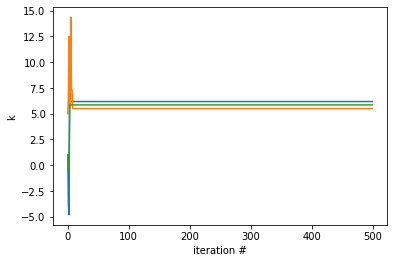

In [11]:
plt.figure()
for n in range(len(model.thetas)):
    ks_list= [theta[3] for theta in model.thetas[n]]
    plt.plot(ks_list[:500]) # only first 500
plt.xlabel('iteration #')
plt.ylabel('k')
plt.show()

[1, 2, 3, 4]